# Introduction to PyTorch and Poutyne

In this notebook, we train a simple fully-connected network and a simple convolutional network on MNIST. First, we train it by coding our own training loop as the PyTorch library expects of us to. Then, we use Poutyne to simplify our code.

Let's install the latest version of Poutyne (if it's not already) and import all the needed packages.

In [1]:
%pip install --upgrade poutyne
# %pip install --upgrade colorama # Uncomment this line to enable colors.
%matplotlib inline
import os
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
from torchvision import transforms, utils
from torchvision.datasets.mnist import MNIST

from poutyne import set_seeds, Model, ModelCheckpoint, CSVLogger, Experiment

Also, we need to set Python's, NumPy's and PyTorch's seeds by using Poutyne function so that our training is (almost) reproducible.

In [2]:
set_seeds(42)

## Basis of Training a Neural Network

In **stochastic gradient descent**, a **batch** of `m` examples are drawn from the train dataset. In the so-called forward pass, these examples are passed through the neural network and an average of their loss values is done. In the backward pass, the average loss is backpropagated through the network to compute the gradient of each parameter. In practice, the `m` examples of a batch are drawn without replacement. Thus, we define one **epoch** of training being the number of batches needed to loop through the entire training dataset.

In addition to the training dataset, a **validation dataset** is used to evaluate the neural network at the end of each epoch. This validation dataset can be used to select the best model during training and thus avoiding overfitting the training set. It also can have other uses such as selecting hyperparameters

Finally, a **test dataset** is used at the end to evaluate the final model.

### Training constants

Now, let's set our training constants. We first have the CUDA device used for training if one is present. Second, we set the train_split to 0.8 (80%) to use 80% of the dataset for training and 20% for testing the trained model. Third, we set the number of classes (i.e. one for each number). Finally, we set the batch size (i.e. the number of elements to see before updating the model), the learning rate for the optimizer, and the number of epochs (i.e. the number of times we see the full dataset).


In [3]:
cuda_device = 0
device = torch.device("cuda:%d" % cuda_device if torch.cuda.is_available() else "cpu")

train_split_percent = 0.8

num_classes = 10

batch_size = 32
learning_rate = 0.1
num_epochs = 5

### Loading the MNIST dataset

The following code helps load the MNIST dataset and creates the PyTorch DataLoaders that split our datasets into batches. The train DataLoader shuffles the examples of the train dataset to draw the examples without replacement.

In [4]:
full_train_dataset = MNIST('./datasets/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('./datasets/', train=False, download=True, transform=transforms.ToTensor())

num_data = len(full_train_dataset)
train_length = int(math.floor(train_split_percent * num_data))
valid_length = num_data - train_length

train_dataset, valid_dataset = random_split(
    full_train_dataset,
    [train_length, valid_length],
    generator=torch.Generator().manual_seed(42),
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

Let's look at some examples of the dataset by looking at the first batch in our train DataLoader and formatting it into a grid and plotting it.

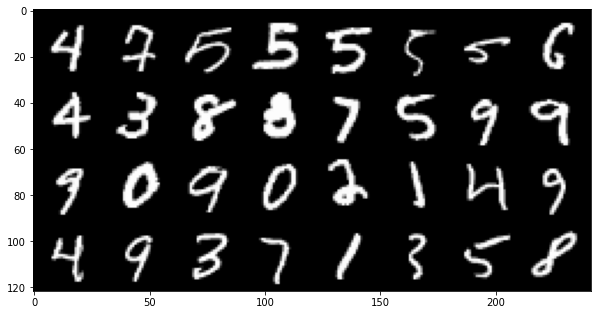

In [5]:
inputs = next(iter(train_loader))[0]
input_grid = utils.make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

### Neural Network Architectures

We train a fully-connected neural network and a convolutional neural network with approximately the same number of parameters.

#### Fully-connected Network
In short, the fully-connected network follows this architecture: ``Input -> [Linear -> ReLU]*3 -> Linear``. The following table shows it in details:

| Layer Type                  | Output Size |       # of Parameters       |
|-----------------------------|:-----------:|:---------------------------:|
| Input                       |   1x28x28   |              0              |
| Flatten                     |  1\*28\*28  |              0              |
| **Linear with 256 neurons** |     256     | 28\*28\*256 + 256 = 200,960 |
| ReLU                        |      *      |              0              |
| **Linear with 128 neurons** |     128     |   256*128 + 128 = 32,896    |
| ReLU                        |      *      |              0              |
| **Linear with 64 neurons**  |     64      |     128*64 + 64 = 8,256     |
| ReLU                        |      *      |              0              |
| **Linear with 10 neurons**  |      10     |      64*10 + 10 = 650       |

Total # of parameters of the fully-connected network: 242,762

#### Convolutional Network

The convolutional neural network architecture starts with some convolution and max-pooling layers. These are then followed by fully-connected layers. We calculate the total number of parameters that the network needs. In short, the convolutional network follows this architecture: ``Input -> [Conv -> ReLU -> MaxPool]*2 -> Dropout -> Linear -> ReLU -> Dropout -> Linear``. The following table shows it in details:

| Layer Type                                     | Output Size |        # of Parameters        |
|------------------------------------------------|:-----------:|:-----------------------------:|
| Input                                          |   1x28x28   |               0               |
| **Conv with 16 3x3 filters with padding of 1** |   16x28x28  |    16\*1\*3\*3 + 16 = 160     |
| ReLU                                           |   16x28x28  |               0               |
| MaxPool 2x2                                    |   16x14x14  |               0               |
| **Conv with 32 3x3 filters with padding of 1** |   32x14x14  |   32\*16\*3\*3 + 32 = 4,640   |
| ReLU                                           |   32x14x14  |               0               |
| MaxPool 2x2                                    |    32x7x7   |               0               |
| Dropout of 0.25                                |    32x7x7   |               0               |
| Flatten                                        |   32\*7\*7  |               0               |
| **Linear with 128 neurons**                    |     128     | 32\*7\*7\*128 + 128 = 200,832 |
| ReLU                                           |     128     |               0               |
| Dropout of 0.5                                 |     128     |               0               |
| **Linear with 10 neurons**                     |      10     |        128\*10 + 10 = 1290    |

Total # of parameters of the convolutional network: 206,922

In [6]:
def create_fully_connected_network():
    """
    This function returns the fully-connected network layed out above.
    """
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
    )


def create_convolutional_network():
    """
    This function returns the convolutional network layed out above.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(32 * 7 * 7, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, num_classes),
    )

## Training the PyTorch way 

That is, writing your own training loop.

In [7]:
def pytorch_accuracy(y_pred, y_true):
    """
    Computes the accuracy for a batch of predictions

    Args:
        y_pred (torch.Tensor): the logit predictions of the neural network.
        y_true (torch.Tensor): the ground truths.

    Returns:
        The average accuracy of the batch.
    """
    y_pred = y_pred.argmax(1)
    return (y_pred == y_true).float().mean() * 100


def pytorch_train_one_epoch(pytorch_network, optimizer, loss_function):
    """
    Trains the neural network for one epoch on the train DataLoader.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
        optimizer (torch.optim.Optimizer): The optimizer of the neural network
        loss_function: The loss function.

    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the train DataLoader.
    """
    pytorch_network.train(True)
    with torch.enable_grad():
        loss_sum = 0.0
        acc_sum = 0.0
        example_count = 0
        for (x, y) in train_loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            y_pred = pytorch_network(x)

            loss = loss_function(y_pred, y)

            loss.backward()

            optimizer.step()

            # Since the loss and accuracy are averages for the batch, we multiply
            # them by the the number of examples so that we can do the right
            # averages at the end of the epoch.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc


def pytorch_test(pytorch_network, loader, loss_function):
    """
    Tests the neural network on a DataLoader.

    Args:
        pytorch_network (torch.nn.Module): The neural network to test.
        loader (torch.utils.data.DataLoader): The DataLoader to test on.
        loss_function: The loss function.

    Returns:
        A tuple (loss, accuracy) corresponding to an average of the losses and
        an average of the accuracy, respectively, on the DataLoader.
    """
    pytorch_network.eval()
    with torch.no_grad():
        loss_sum = 0.0
        acc_sum = 0.0
        example_count = 0
        for (x, y) in loader:
            # Transfer batch on GPU if needed.
            x = x.to(device)
            y = y.to(device)

            y_pred = pytorch_network(x)
            loss = loss_function(y_pred, y)

            # Since the loss and accuracy are averages for the batch, we multiply
            # them by the the number of examples so that we can do the right
            # averages at the end of the test.
            loss_sum += float(loss) * len(x)
            acc_sum += float(pytorch_accuracy(y_pred, y)) * len(x)
            example_count += len(x)

    avg_loss = loss_sum / example_count
    avg_acc = acc_sum / example_count
    return avg_loss, avg_acc


def pytorch_train(pytorch_network):
    """
    This function transfers the neural network to the right device,
    trains it for a certain number of epochs, tests at each epoch on
    the validation set and outputs the results on the test set at the
    end of training.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.

    Example:
        This function displays something like this:

        .. code-block:: python

            Epoch 1/5: loss: 0.5026924496193726, acc: 84.26666259765625, val_loss: 0.17258917854229608, val_acc: 94.75
            Epoch 2/5: loss: 0.13690324830015502, acc: 95.73332977294922, val_loss: 0.14024296019474666, val_acc: 95.68333435058594
            Epoch 3/5: loss: 0.08836929737279813, acc: 97.29582977294922, val_loss: 0.10380942322810491, val_acc: 96.66666412353516
            Epoch 4/5: loss: 0.06714504160980383, acc: 97.91874694824219, val_loss: 0.09626663728555043, val_acc: 97.18333435058594
            Epoch 5/5: loss: 0.05063822727650404, acc: 98.42708587646484, val_loss: 0.10017542181412378, val_acc: 96.95833587646484
            Test:
                Loss: 0.09501855444908142
                Accuracy: 97.12999725341797
    """
    print(pytorch_network)

    # Transfer weights on GPU if needed.
    pytorch_network.to(device)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    for epoch in range(1, num_epochs + 1):
        # Training the neural network via backpropagation
        train_loss, train_acc = pytorch_train_one_epoch(pytorch_network, optimizer, loss_function)

        # Validation at the end of the epoch
        valid_loss, valid_acc = pytorch_test(pytorch_network, valid_loader, loss_function)

        print(
            "Epoch {}/{}: loss: {}, acc: {}, val_loss: {}, val_acc: {}".format(
                epoch, num_epochs, train_loss, train_acc, valid_loss, valid_acc
            )
        )

    # Test at the end of the training
    test_loss, test_acc = pytorch_test(pytorch_network, test_loader, loss_function)
    print('Test:\n\tLoss: {}\n\tAccuracy: {}'.format(test_loss, test_acc))

In [8]:
fc_net = create_fully_connected_network()
pytorch_train(fc_net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch 1/5: loss: 0.4982981081654628, acc: 84.46875, val_loss: 0.15822587533543508, val_acc: 95.0
Epoch 2/5: loss: 0.13368912097004554, acc: 95.96666666666667, val_loss: 0.11188255989799897, val_acc: 96.6
Epoch 3/5: loss: 0.09036096389925417, acc: 97.1625, val_loss: 0.12386404728268584, val_acc: 95.85
Epoch 4/5: loss: 0.06672176570573356, acc: 97.89791666666666, val_loss: 0.1249691165064772, val_acc: 96.15
Epoch 5/5: loss: 0.052371635485091245, acc: 98.35208333333334, val_loss: 0.08674932696111501, val_acc: 97.425
Test:
	Loss: 0.08371428851312958
	Accuracy: 97.41


In [9]:
conv_net = create_convolutional_network()
pytorch_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch 1/5: loss: 0.39773683813307437, acc: 86.84583333333333, val_loss: 0.08636753975662093, val_acc: 97.225
Epoch 2/5: loss: 0.12779210423841142, acc: 96.13333333333334, val_loss: 0.06378858245948019, val_acc: 97.98333333333333
Epoch 3/5: loss: 0.09846522739009621, acc: 97.14791666666666, val_loss: 0.05034713152951251, val_acc: 98.475
Epoch 4/5: loss: 0.0847952813663287, acc: 97.39375, val_loss

## Training the Poutyne way

That is, only few lines of code with a better output.

In [10]:
def poutyne_train(pytorch_network):
    """
    This function creates a Poutyne Model (see https://poutyne.org/model.html), sends the Model
    on the specified device, and uses the `fit_generator` method to train the neural network.
    At the end, the `evaluate_generator` is used on  the test set.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    # Poutyne Model on GPU
    model = Model(
        pytorch_network,
        optimizer,
        loss_function,
        batch_metrics=['accuracy'],
        device=device,
    )

    # Train
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs)

    # Test
    test_loss, test_acc = model.evaluate_generator(test_loader)

In [11]:
fc_net = create_fully_connected_network()
poutyne_train(fc_net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch: 1/5 Train steps: 1500 Val steps: 375 7.39s loss: 0.501286 acc: 84.006250 val_loss: 0.169684 val_acc: 94.983333
Epoch: 2/5 Train steps: 1500 Val steps: 375 7.25s loss: 0.135387 acc: 95.881250 val_loss: 0.107233 val_acc: 96.725000
Epoch: 3/5 Train steps: 1500 Val steps: 375 7.57s loss: 0.091741 acc: 97.104167 val_loss: 0.101500 val_acc: 96.941667
Epoch: 4/5 Train steps: 1500 Val steps: 375 7.38s loss: 0.067434 acc: 97.904167 val_loss: 0.095485 val_acc: 97.175000
Epoch: 5/5 Train steps: 1500 Val steps: 375 7.39s loss: 0.052212 acc: 98.329167 val_loss: 0.096475 val_acc: 97.066667
Test steps: 313 0.91s test_loss: 0.086705 test_acc: 97.320000                

In [12]:
conv_net = create_convolutional_network()
poutyne_train(conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/5 Train steps: 1500 Val steps: 375 8.26s loss: 0.382591 acc: 87.731250 val_loss: 0.078990 val_acc: 97.508333
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.49s loss: 0.132515 acc: 96.102083 val_loss: 0.058858 val_acc: 98.158333
Epoch: 3/5 Train steps: 1500 Val steps: 375 8.28s loss: 0.102149 acc: 96.947917 val_loss: 0.049142 val_acc: 98.458333
Epoch: 4/5 Train steps: 1500 Val steps: 375 

## Poutyne Callbacks

One nice feature of Poutyne is [callbacks](https://poutyne.org/callbacks.html). Callbacks allow to do actions during training of the neural network. In the following example, we use 3 callbacks. One that saves the latest weights in a file to be able to continue the optimization at the end of training if more epochs are needed. Another one that saves the best weights according to the performance on the validation dataset. Finally, another one that saves the displayed logs into a TSV file.

In [13]:
def train_with_callbacks(name, pytorch_network):
    """
    In addition to the the `poutyne_train`, this function saves checkpoints and logs as described above.

    Args:
        name (str): a name used to save logs and checkpoints.
        pytorch_network (torch.nn.Module): The neural network to train.
    """
    print(pytorch_network)

    # We are saving everything into ./saves/{name}.
    save_path = os.path.join('saves', name)

    # Creating saving directory if necessary.
    os.makedirs(save_path, exist_ok=True)

    callbacks = [
        # Save the latest weights to be able to continue the optimization at the end for more epochs.
        ModelCheckpoint(os.path.join(save_path, 'last_epoch.ckpt')),
        # Save the weights in a new file when the current model is better than all previous models.
        ModelCheckpoint(
            os.path.join(save_path, 'best_epoch_{epoch}.ckpt'),
            monitor='val_acc',
            mode='max',
            save_best_only=True,
            restore_best=True,
            verbose=True,
        ),
        # Save the losses and accuracies for each epoch in a TSV.
        CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
    ]

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)
    loss_function = nn.CrossEntropyLoss()

    model = Model(
        pytorch_network,
        optimizer,
        loss_function,
        batch_metrics=['accuracy'],
        device=device,
    )
    model.fit_generator(train_loader, valid_loader, epochs=num_epochs, callbacks=callbacks)

    test_loss, test_acc = model.evaluate_generator(test_loader)

In [14]:
fc_net = create_fully_connected_network()
train_with_callbacks('fc', fc_net)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): ReLU()
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
)
Epoch: 1/5 Train steps: 1500 Val steps: 375 7.33s loss: 0.503523 acc: 84.047917 val_loss: 0.179884 val_acc: 94.591667
Epoch 1: val_acc improved from -inf to 94.59167, saving file to saves/fc/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 7.54s loss: 0.137898 acc: 95.810417 val_loss: 0.124009 val_acc: 96.100000
Epoch 2: val_acc improved from 94.59167 to 96.10000, saving file to saves/fc/best_epoch_2.ckpt
Epoch: 3/5 Train steps: 1500 Val steps: 375 7.32s loss: 0.091730 acc: 97.204167 val_loss: 0.101482 val_acc: 96.858333
Epoch 3: val_acc improved from 96.10000 to 96.85833, saving file to saves/fc/best_epoch_3.ckpt
Epoch: 4/5 Train steps: 1500 Val

In [15]:
conv_net = create_convolutional_network()
train_with_callbacks('conv', conv_net)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/5 Train steps: 1500 Val steps: 375 8.54s loss: 0.372035 acc: 87.935417 val_loss: 0.080718 val_acc: 97.458333
Epoch 1: val_acc improved from -inf to 97.45833, saving file to saves/conv/best_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 8.43s loss: 0.128623 acc: 96.195833 val_loss: 0.055256 val_acc: 98.200000
Epoch 2: val_acc improved from 97.45833 to 98.20000, saving file to s

## Making Your Own Callback

While Poutyne provides a great number of [predefined callbacks](https://poutyne.org/callbacks.html), it is sometimes useful to make your own callback. In addition to the [documentation](https://poutyne.org/callbacks.html#poutyne.framework.callbacks.Callback) of the Callback class, see the [Tips and Tricks notebook](https://github.com/GRAAL-Research/poutyne/blob/master/examples/tips_and_tricks.ipynb) for an example.

## Poutyne Experiment
Most of the time when using Poutyne (or even Pytorch in general), we will find ourselves in an iterative model hyperparameters finetuning loop. For efficient model search, we will usually wish to save our best performing models, their training and testing statistics and even sometimes wish to retrain an already trained model for further tuning. All of the above can be easily implemented with the flexibility of Poutyne Callbacks, but having to define and initialize each and every Callback object we wish for our model quickly feels cumbersome.

This is why Poutyne provides an [Experiment class](https://poutyne.org/experiment.html), which aims specifically at enabling quick model iteration search, while not sacrifying on the quality of a single experiment - statistics logging, best models saving, etc. Experiment is actually a simple wrapper between a PyTorch network and Poutyne's core Callback objects for logging and saving. Given a working directory where to output the various logging files and a PyTorch network, the Experiment class reduces the whole training loop to a single line.

The following code uses [Poutyne's Experiment class](https://poutyne.org/experiment.html) to train a network for 5 epochs. The code is quite simpler than the code in the Poutyne Callbacks section while doing more (only 3 lines). Once trained for 5 epochs, it is then possible to resume the optimization at the 5th epoch for 5 more epochs until the 10th epoch using the same function.

In [16]:
def experiment_train(pytorch_network, name, epochs=5):
    """
    This function creates a Poutyne Experiment, trains the input module
    on the train loader and then tests its performance on the test loader.
    All training and testing statistics are saved, as well as best model
    checkpoints.

    Args:
        pytorch_network (torch.nn.Module): The neural network to train.
        working_directory (str): The directory where to output files to save.
        epochs (int): The number of epochs. (Default: 5)
    """
    print(pytorch_network)

    optimizer = optim.SGD(pytorch_network.parameters(), lr=learning_rate)

    # Everything is going to be saved in ./saves/{name}.
    save_path = os.path.join('saves', name)

    # Poutyne Experiment
    expt = Experiment(
        save_path,
        pytorch_network,
        device=device,
        optimizer=optimizer,
        task='classif',
    )

    # Train
    expt.train(train_loader, valid_loader, epochs=epochs)

    # Test
    expt.test(test_loader)

Let's first remove the output directory if it exists so that we start training from scratch.

In [17]:
shutil.rmtree('saves/convnet_mnist_experiment', ignore_errors=True)

Let's train for 5 epochs.

In [18]:
conv_net = create_convolutional_network()
experiment_train(conv_net, 'conv_net_experiment', epochs=5)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Epoch: 1/5 Train steps: 1500 Val steps: 375 10.68s loss: 0.356066 acc: 88.406250 fscore_micro: 0.884063 val_loss: 0.077794 val_acc: 97.600000 val_fscore_micro: 0.976000
Epoch 1: val_acc improved from -inf to 97.60000, saving file to saves/conv_net_experiment/checkpoint_epoch_1.ckpt
Epoch: 2/5 Train steps: 1500 Val steps: 375 10.56s loss: 0.124052 acc: 96.285417 fscore_micro: 0.962854 val_loss: 0

In [19]:
conv_net = create_convolutional_network()
experiment_train(conv_net, 'conv_net_experiment', epochs=10)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Dropout(p=0.25, inplace=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=1568, out_features=128, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.5, inplace=False)
  (11): Linear(in_features=128, out_features=10, bias=True)
)
Loading weights from saves/conv_net_experiment/checkpoint.ckpt and starting at epoch 6.
Loading optimizer state from saves/conv_net_experiment/checkpoint.optim and starting at epoch 6.
Epoch:  6/10 Train steps: 1500 Val steps: 375 10.77s loss: 0.054071 acc: 98.347917 fscore_micro: 0.983479 val_loss: 0.037591 val_acc: 98.833333 val_fscore_micro: 0.988333
Epoch 6: val_acc improved from 98.61667 to

## Next Step
We have plenty more examples for you, see [this](https://github.com/GRAAL-Research/poutyne/blob/master/examples/tips_and_tricks.ipynb) notebook for tips and tricks using Poutyne, this [one](https://github.com/GRAAL-Research/poutyne/blob/master/examples/policy_cifar_example.ipynb) and this [one](https://github.com/GRAAL-Research/poutyne/blob/master/examples/policy_interface.ipynb) for policy examples or this [one](https://github.com/GRAAL-Research/poutyne/blob/master/examples/transfer_learning.ipynb) for a transfer learning example.